# PF for SDE SIR Model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

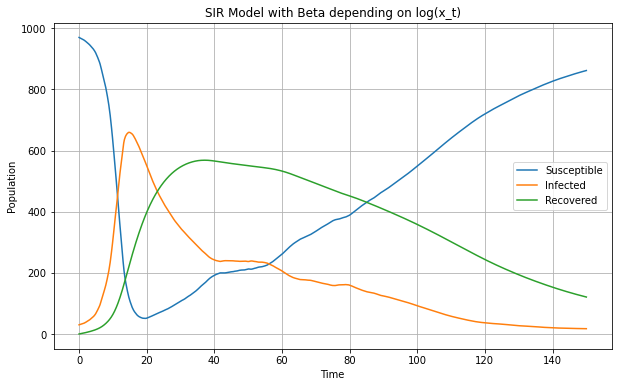

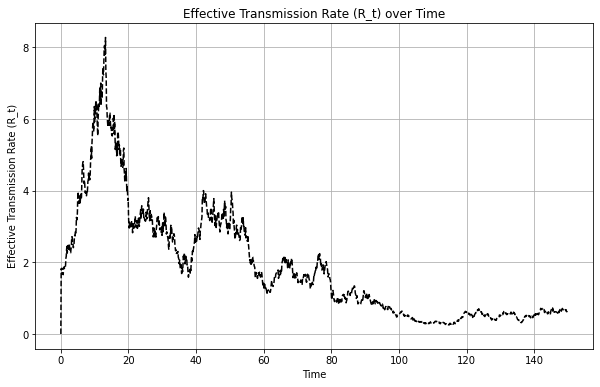

In [329]:
# Parameters
N = 1000 # Total population
R_initial = 2 # Initial reproduction number
t_max = 150 # Simulation time
m = 10
dt = 1/m  # Time step
alpha = 1/30 # Rate of immunity loss
gamma = 1/14 # Recovery rate
sigma = 0.15 # Diffusion coefficient

# Initial conditions
I0 = 30
S0 = N - I0
R0 = 0

# Euler-Maruyama method for SIR model with beta depending on log(x_t)
def euler_maruyama_sir(S0, I0, R0, R_initial, t_max, dt, alpha, sigma):
    num_steps = int(t_max / dt)
    t = np.linspace(0, t_max, num_steps)
    S = np.zeros(num_steps)
    I = np.zeros(num_steps)
    R = np.zeros(num_steps)
    X1 = np.zeros(num_steps)
    R_t = np.zeros(num_steps)

    beta_t = np.zeros(num_steps)
    S[0], I[0], R[0], beta_t[0], X1[0] = S0, I0, R0, R_initial, np.log(R_initial)
    for i in range(1, num_steps):
        dW1 = np.random.normal(0, np.sqrt(dt))  # Wiener process increment
        X1[i] = X1[i-1] + sigma * dW1  # Update X using the drift and diffusion terms
        R_t[i] = np.exp(X1[i])
        dS = -(gamma+alpha)*R_t[i] * S[i - 1] * I[i - 1] / N + alpha * R[i - 1]
        dI = (gamma+alpha)*R_t[i] * S[i - 1] * I[i - 1] / N - gamma*I[i - 1]
        dR = gamma*I[i - 1] - alpha * R[i - 1]
        S[i] = S[i - 1] + dS * dt
        I[i] = I[i - 1] + dI * dt
        R[i] = R[i - 1] + dR * dt
    return t, S, I, R, R_t, gamma # Return exp(log_beta_values) for plotting

# Simulate the model
t, S, I, R, R_t, gamma= euler_maruyama_sir(S0, I0, R0, R_initial, t_max, dt, alpha, sigma)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible')
plt.plot(t, I, label='Infected')
plt.plot(t, R, label='Recovered')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('SIR Model with Beta depending on log(x_t)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t, R_t,  linestyle='--', color='black')
plt.xlabel('Time')
plt.ylabel('Effective Transmission Rate (R_t)')
plt.title('Effective Transmission Rate (R_t) over Time')
plt.grid(True)
plt.show()

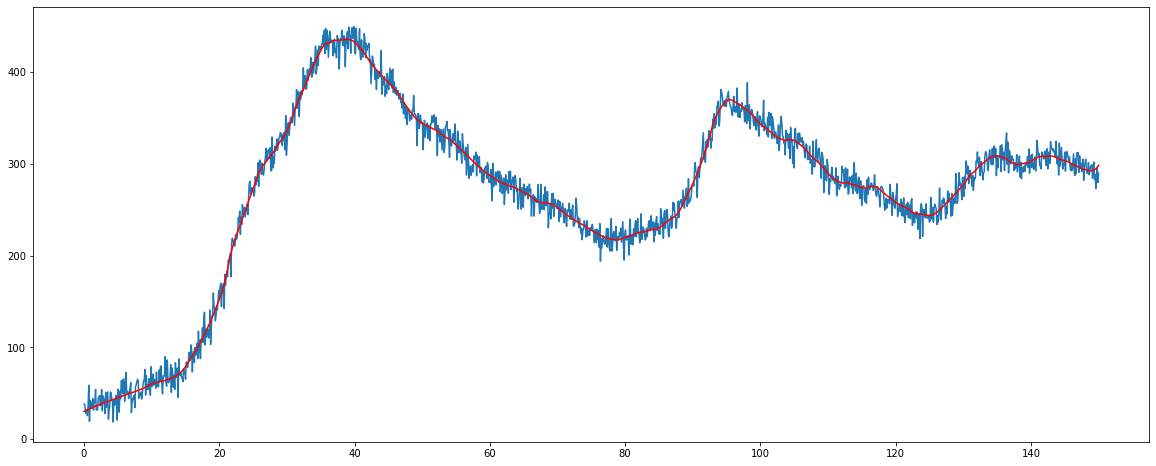

In [289]:
#Add some noise for a synthetic exercise
observations = I + stats.norm(0,10).rvs(len(I))

plt.figure(figsize=(20, 8))
plt.plot(t, observations)
plt.plot(t, I, color='red')
plt.show()

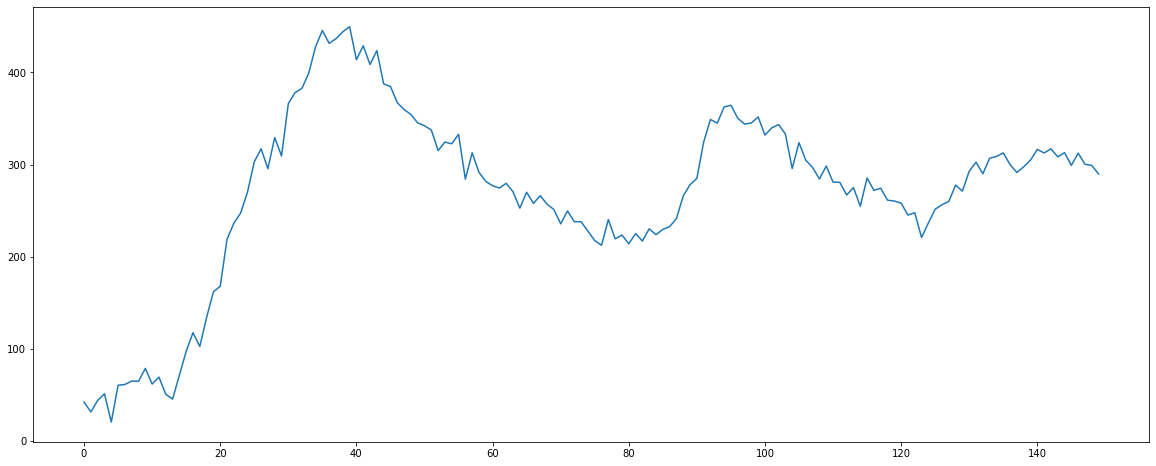

In [290]:
#Get rid of the Euler Murayama time steps
weekly_obs = observations.reshape(t_max, m)[:,-1]

RT_new = R_t.reshape(t_max,m)[:,-1]

#remainder = len(daily_obs) % 7

# Reshape the array to make it divisible by 7
#if remainder > 0:
#    daily_obs = np.concatenate((daily_obs, np.zeros(7 - remainder)))

# Reshape into weekly intervals and sum the values
plt.figure(figsize=(20, 8))
plt.plot(weekly_obs)
plt.show()

In [291]:
#Define Euler Murayama SIR that computes the discretization for paths between t and t+1 day
def one_step_euler_maruyama_sir(num_particles, m, N, initial_states, params):
    dt = 1/m
    alpha, gamma, sigma = params

    num_states = initial_states.shape[1]
    
    states = np.zeros((m+1,num_particles,num_states))
    
    states[0,:,:] = initial_states
        
    for t in range(1, m+1):
        dW = np.random.normal(0, np.sqrt(dt), size=num_particles) 
        states[t, :, 3] = states[t-1, :, 3] + sigma * dW 
        RT = np.exp(states[t, :, 3])
        
        dS = -(gamma+alpha)*RT*states[t-1, :, 0]*states[t-1, :, 1]/N + alpha*states[t-1, :, 2]
        dI =  (gamma+alpha)*RT*states[t-1, :, 0]*states[t-1, :, 1]/N - gamma*states[t-1, :, 1]
        dR =  gamma*states[t-1, :, 1] - alpha*states[t-1, :, 2]
        
        states[t, :, 0] = states[t-1, :, 0] + dS*dt
        states[t, :, 1] = states[t-1, :, 1] + dI*dt
        states[t, :, 2] = states[t-1, :, 2] + dR*dt
        
    return states[-1,:,:]

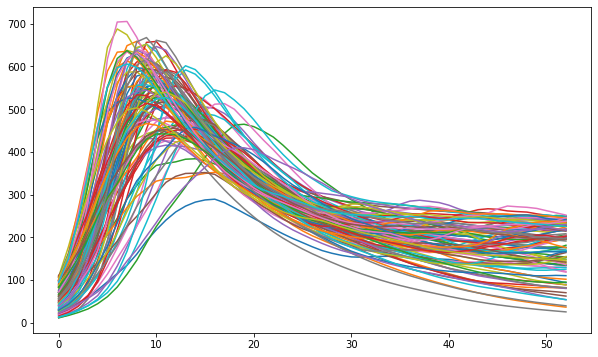

In [292]:
# Parameters
N = 1000  # Total population
num_particles = 100
m = 10
alpha = 1/30  # Rate of immunity loss
gamma = 0.1  # Recovery rate
sigma = 0.12# Diffusion coefficient

params = (alpha, gamma, sigma)

# Initial conditions
I0 = stats.uniform(10,100).rvs(num_particles)
S0 = N - I0
R0 = np.zeros(num_particles)
X0 = np.log(np.random.normal(4,0.5, size=num_particles))

initial_states = np.column_stack((S0, I0, R0, X0))
num_states = initial_states.shape[1]

# Simulate the SIR model for t = 50 periods
T = 52
state_values = np.zeros((T+1, num_particles, num_states))

# Initial conditions for the first simulation
state_values[0,:,:] = initial_states

for t in np.arange(1,T+1):
    # Simulate the SIR model
    final_states = one_step_euler_maruyama_sir(num_particles, m, N, initial_states, params)
    
    # Store the final states
    state_values[t,:,:] = final_states
    
    # Update initial conditions for the next simulation
    initial_states = final_states


# Plot the results
plt.figure(figsize=(10, 6))
for particle in np.arange(0,num_particles):
    plt.plot(np.arange(T+1),state_values[:,particle,1])
plt.show()

In [301]:
def sir_bootstrap_particle_filter(y, parameters, num_particles, m, initial_states):
    num_compartments = initial_states.shape[1]  # S, I, R, R_t, X
    t_max = y.shape[0]
        
    particles = np.zeros((t_max, num_particles, num_compartments))
    weights = np.zeros((t_max, num_particles))
    norm_weights = np.zeros((t_max, num_particles))
    ancestry_matrix = np.zeros((t_max, num_particles))
    ESS = np.zeros(t_max)
    
    # Initialization
    particles[0, :, 0] = initial_states[:,0]     # S_t
    particles[0, :, 1] = initial_states[:,1]     # I_t              
    particles[0, :, 2] = initial_states[:,2]     # R_t 
    particles[0, :, 3] = initial_states[:,3]     # X_t
    
    #weights[0,:] = 1/num_particles
    #norm_weights[0,:] = weights[0,:]
    ancestry_matrix[0,:] = np.arange(num_particles)
    
    incremental_weights = stats.norm(particles[0, :, 1], 5).logpdf(y[0]) 
    max_weights = np.max(incremental_weights)
    weights[0, :] = np.exp(incremental_weights-max_weights) #*weights[t-1, :]
    weights_sum = np.sum(weights[0,:])
    norm_weights[0,:] = weights[0,:] / weights_sum
    ESS[0] = 1 / np.sum(norm_weights**2)
    
    
    loglikelihood = max_weights + np.log(weights_sum) - np.log(num_particles)
    
    #loglikelihood = 0
    #ESS[0] = num_particles
    
    for t in range(1, t_max):
        if ESS[t-1] < 0.5*num_particles:
            #Systemtic resampling
            cumulative_sum = np.cumsum(norm_weights[t-1,:])
            random_start = np.random.uniform(0, 1/num_particles)
            new_ancestors = np.zeros(num_particles, dtype=int)
            for i in range(num_particles):
                idx = np.searchsorted(cumulative_sum, random_start + i/num_particles)
                new_ancestors[i] = idx
            
            #Multinomial resampling
            #new_ancestors = np.random.choice(np.arange(num_particles), size=num_particles, p=norm_weights[t-1,:], replace=True) #resample particles
        
            # Update the ancestry matrix
            ancestry_matrix[1:t-1,:] = ancestry_matrix[1:t-1, new_ancestors]
            ancestry_matrix[t,:] = new_ancestors
        else:
            new_ancestors = ancestry_matrix[t-1,:].astype(int)
            ancestry_matrix[t,:] = new_ancestors
            
        #State Transition with Euler-Murayama for m steps
        particles[t, :, :] = one_step_euler_maruyama_sir(num_particles, m, N, particles[t-1, new_ancestors, :], parameters)
        
        #Compute Weights
        incremental_weights = stats.norm(particles[t, :, 1], 25).logpdf(y[t]) 
        max_weights = np.max(incremental_weights)
        weights[t, :] = np.exp(incremental_weights-max_weights)#*weights[t-1, :]
        weights_sum = np.sum(weights[t,:])
        norm_weights[t,:] = weights[t,:] / weights_sum
        ESS[t] = 1 / np.sum(norm_weights**2)
        
        loglikelihood += max_weights + np.log(weights_sum) - np.log(num_particles)
    return loglikelihood, particles, ancestry_matrix, ESS

-670.4941097483039


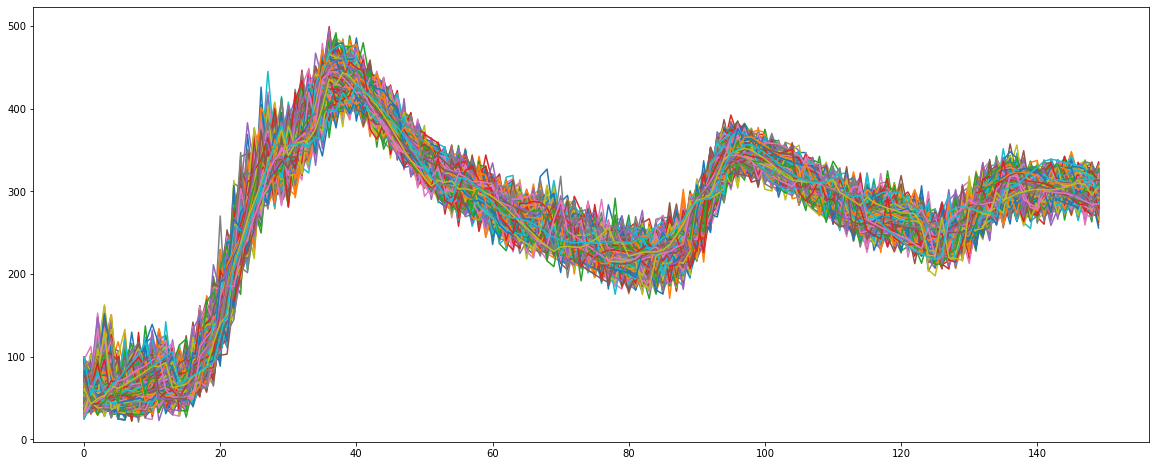

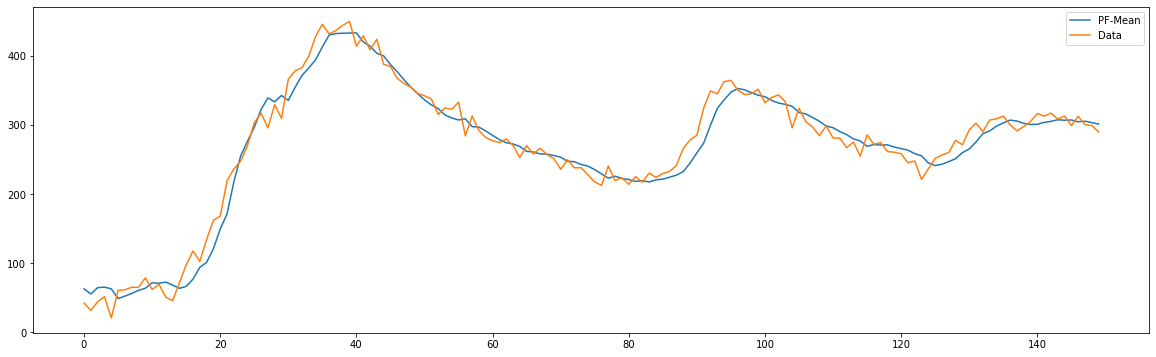

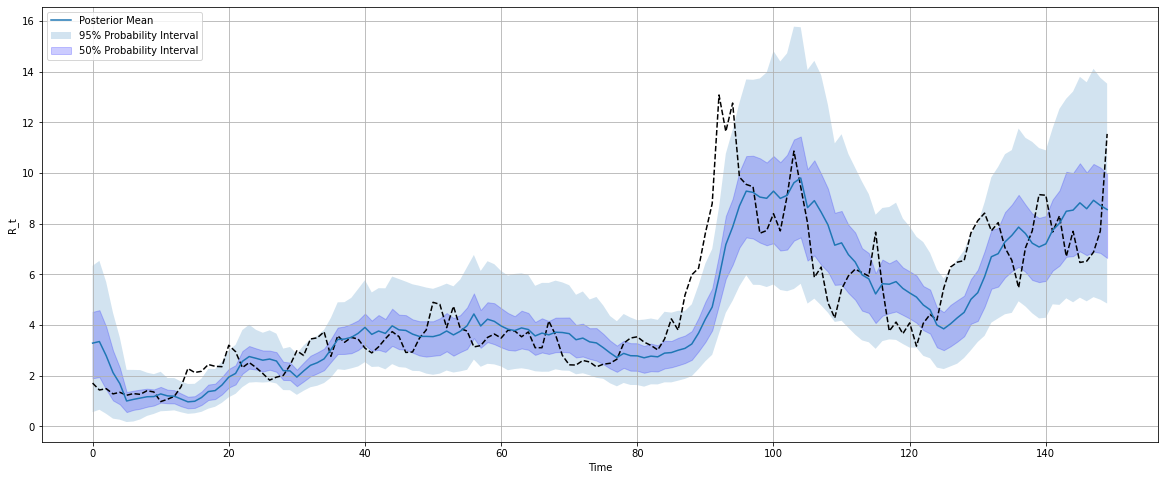

In [302]:
#Parameters and initial values
N = 1000 # Total population
m = 10 # Euler-Murayama discretization steps
num_particles = 1000
t_max = weekly_obs.shape[0]

alpha = 1/30 # Rate of immunity loss
gamma = 1/14 # Recovery rate
sigma = 0.12# Diffusion coefficient
params = (alpha, gamma, sigma)
priorR0 = 3
# Initial conditions
I0 = stats.uniform(25,75).rvs(num_particles)
S0 = N - I0
R0 = np.zeros(num_particles)
X0 = np.log(stats.truncnorm(-priorR0/2,np.inf,priorR0,2).rvs(num_particles))

initial_states = np.column_stack((S0, I0, R0, X0))
num_compartments = initial_states.shape[1]

## Test Run
loglikelihood = 0
particles = np.zeros((t_max, num_particles, num_compartments))
ancestry_matrix = np.zeros((t_max, num_particles))
ESS = np.zeros(t_max)
loglikelihood, particles, ancestry_matrix, ESS = sir_bootstrap_particle_filter(weekly_obs, params, num_particles, m, initial_states)
print(loglikelihood)

# Plot the results
plt.figure(figsize=(20, 8))
for particle in np.arange(num_particles):
    plt.plot(np.arange(t_max),particles[:,particle,1])
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(np.mean(particles[:,:,1], axis=1), label='PF-Mean')
plt.plot(weekly_obs, label='Data')
plt.legend()
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(np.arange(t_max), RT_new,  linestyle='--', color='black')
plt.plot(np.arange(t_max), np.mean(np.exp(particles[:, :, 3]), axis=1), label='Posterior Mean')
plt.fill_between(np.arange(t_max), np.percentile(np.exp(particles[:, :, 3]), 5, axis=1), np.percentile(np.exp(particles[:, :, 3]), 95, axis=1), alpha=0.2, label='95% Probability Interval')
plt.fill_between(np.arange(t_max), np.percentile(np.exp(particles[:, :, 3]), 25, axis=1), np.percentile(np.exp(particles[:, :, 3]), 75, axis=1), alpha=0.2, label='50% Probability Interval', color='blue')
plt.xlabel('Time')
plt.ylabel('R_t')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [303]:
def sample_trajectory(ancestry_matrix, particles_matrix):
    num_time_steps = particles_matrix.shape[0]
    num_particles = particles_matrix.shape[1]
    num_states = particles_matrix.shape[2]
    trajectory = np.zeros((num_time_steps, num_states))  # Initialize the trajectory array
    
    # Sample the particle index from the last time step
    sampled_index = np.random.choice(np.arange(num_particles)).astype(int)
    trajectory[-1,:] = particles_matrix[-1,sampled_index,:]
    
    # Recursively sample particles from previous time steps
    for t in range(num_time_steps - 2, -1, -1):  # Iterate backward in time
        # Get the ancestor index at the previous time step
        sampled_index = ancestry_matrix[t, sampled_index].astype(int)
        # Update the trajectory array with the state from the particles matrix
        trajectory[t,:] = particles_matrix[t, sampled_index,:]
    
    return trajectory

In [304]:
covid = pd.read_csv('/Users/ro/Desktop/UNDERGRAD_AM_THESIS/national_weekly.csv',  parse_dates=['Date'], index_col=False)
# Set the index to the dates column
covid.set_index('Date', inplace=True)
# Display the DataFrame to verify
covid.head()

,Infections,Deaths,Year
Date,,,
2020-02-23,4.0,0.0,2020
2020-03-01,22.0,0.0,2020
2020-03-08,127.0,0.0,2020
2020-03-15,621.0,0.0,2020
2020-03-22,1146.0,6.0,2020


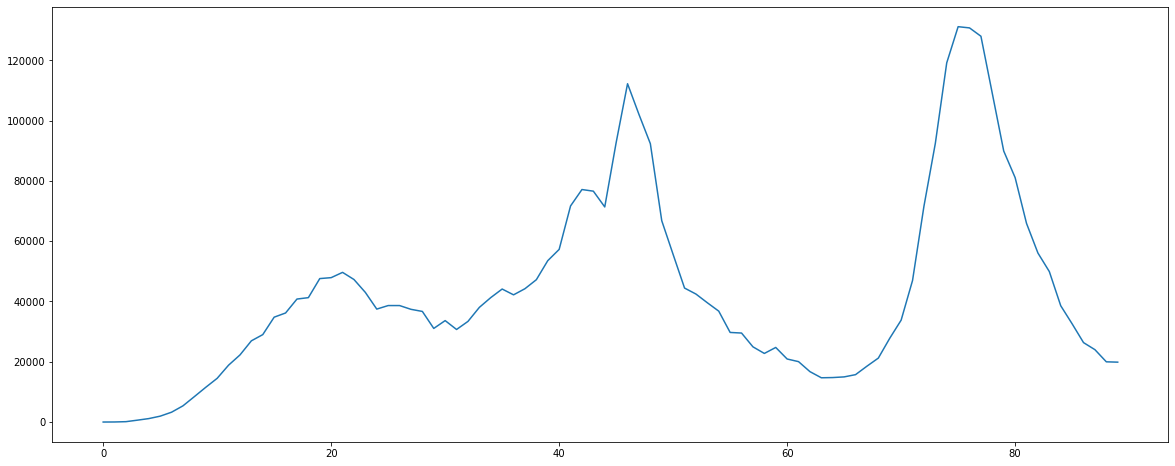

In [234]:
test_data = covid['Infections'].values[0:90]
plt.figure(figsize=(20,8))
plt.plot(test_data)
plt.show()

In [332]:
num_particles = 1000
num_iterations = 5000

N = 127792286  # Total population
m = 14

R0_current = 3.5

I0 = stats.uniform(1,10).rvs(num_particles)
S0 = N - I0
R0 = np.zeros(num_particles)
X0_current = np.log(stats.truncnorm(-R0_current/0.5, np.inf, R0_current,0.5).rvs(num_particles))

initial_states = np.column_stack((S0, I0, R0, X0_current))

num_states = initial_states.shape[1]
num_time_steps = test_data.shape[0]

estimated_alpha = np.zeros((num_iterations))
estimated_gamma = np.zeros((num_iterations))
estimated_sigma = np.zeros((num_iterations))
estimated_R0 = np.zeros((num_iterations))

trajectories = np.zeros((num_iterations,num_time_steps, num_states))

loglikelihood = np.zeros((num_iterations))

alpha_current = 0.2
gamma_current = 0.8
sigma_current = 0.5
params_initial = (alpha_current, gamma_current, sigma_current)

estimated_alpha[0] = alpha_current
estimated_gamma[0] = gamma_current
estimated_sigma[0] = sigma_current
estimated_R0[0] = R0_current

accepted = 0

likelihood_current, particles, ancestry_matrix, ESS = sir_bootstrap_particle_filter(test_data, params_initial, num_particles, m, initial_states)
trajectories[0,:,:] = sample_trajectory(ancestry_matrix, particles)
loglikelihood[0] = likelihood_current
print(loglikelihood[0])
# Perform PMMH iterations
for i in range(num_iterations):
    # Propose a new value for X0
    alpha_proposed = np.random.normal(alpha_current, 0.05)
    gamma_proposed = np.random.normal(gamma_current, 0.05)
    sigma_proposed = np.random.normal(sigma_current, 0.05)
    R0_proposed = np.random.normal(R0_current, 0.5)
    
    X0_proposed = np.log(stats.truncnorm(-R0_current/0.5, np.inf, R0_proposed,0.5).rvs(num_particles))
    
    if (0 < alpha_proposed < 1) and (0 < gamma_proposed < 1) and (0 < sigma_proposed < 1) and (R0_proposed > 0):
        params_proposed = (alpha_proposed, gamma_proposed, sigma_proposed)
        initial_states = np.column_stack((S0, I0, R0, X0_proposed))
        likelihood_proposed, particles, ancestry_matrix, ESS  = sir_bootstrap_particle_filter(test_data, params_proposed, num_particles, m, initial_states)
        trajectory_proposed = sample_trajectory(ancestry_matrix, particles)
    
    # Calculate acceptance probability
    acceptance_prob = min(1, np.exp(likelihood_proposed - likelihood_current))
    acceptance_prob *= (0 < alpha_proposed < 1)
    acceptance_prob *= (0 < gamma_proposed < 1)
    acceptance_prob *= (0 < sigma_proposed < 1)
    acceptance_prob *= (R0_proposed > 0)

    u = stats.uniform(0,1).rvs()
    # Accept or reject the proposal
    if u < acceptance_prob:
        alpha_current = alpha_proposed
        gamma_current = gamma_proposed
        sigma_current = sigma_proposed
        R0_current = R0_proposed
        likelihood_current = likelihood_proposed
        
        trajectories[i,:,:] = trajectory_proposed
        accepted += 1
    else:
        trajectories[i,:,:] = trajectories[i-1,:,:]
        
    estimated_alpha[i] = alpha_current
    estimated_gamma[i] = gamma_current
    estimated_sigma[i] = sigma_current
    estimated_R0[i] = R0_current
    loglikelihood[i] = likelihood_current
    
    if (i % 1000 == 0) and (i>0):
        print('Acceptance rate: ', accepted/(i))
        print('Loglikelihood: ', loglikelihood[i])
        print('R0: ', R0_current)
        print('Alpha: ', alpha_current)
        print('Gamma: ', gamma_current)
        print('Sigma: ', sigma_current)

-1403.4094023166135


/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_66632/2218021035.py:52: RuntimeWarning: invalid value encountered in log
  X0_proposed = np.log(stats.truncnorm(-R0_current/0.5, np.inf, R0_proposed,0.5).rvs(num_particles))
/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_66632/433783123.py:17: RuntimeWarning: overflow encountered in multiply
  dS = -(gamma+alpha)*RT*states[t-1, :, 0]*states[t-1, :, 1]/N + alpha*states[t-1, :, 2]
/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_66632/433783123.py:18: RuntimeWarning: overflow encountered in multiply
  dI =  (gamma+alpha)*RT*states[t-1, :, 0]*states[t-1, :, 1]/N - gamma*states[t-1, :, 1]
/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_66632/433783123.py:18: RuntimeWarning: invalid value encountered in subtract
  dI =  (gamma+alpha)*RT*states[t-1, :, 0]*states[t-1, :, 1]/N - gamma*states[t-1, :, 1]
/Users/ro/opt/anaconda3/envs/codigosTesis/lib/python3.9/site-packages/scipy/stats/_continuous_distns.p

Acceptance rate:  0.08
Loglikelihood:  -911.0930549446211
R0:  5.467380923009365
Alpha:  0.20568378979104535
Gamma:  0.4421586929186804
Sigma:  0.7280551205749759
Acceptance rate:  0.041
Loglikelihood:  -905.5570244064157
R0:  5.16385071222277
Alpha:  0.10646334006452757
Gamma:  0.4798841314816038
Sigma:  0.6471521457283195
Acceptance rate:  0.027333333333333334
Loglikelihood:  -905.5570244064157
R0:  5.16385071222277
Alpha:  0.10646334006452757
Gamma:  0.4798841314816038
Sigma:  0.6471521457283195
Acceptance rate:  0.0205
Loglikelihood:  -905.5570244064157
R0:  5.16385071222277
Alpha:  0.10646334006452757
Gamma:  0.4798841314816038
Sigma:  0.6471521457283195


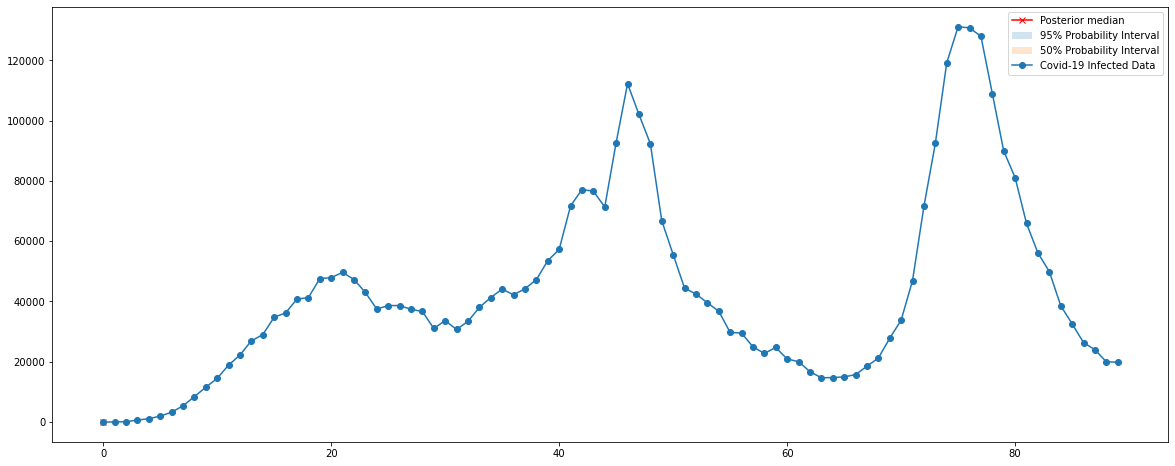

In [330]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(test_data.shape[0]), np.mean(trajectories[:5000, :, 1], axis=0), color='red', marker='x', label= 'Posterior median')
plt.fill_between(np.arange(test_data.shape[0]), np.percentile(trajectories[:5000, :, 1], 2.5, axis=0), np.percentile(trajectories[:5000, :, 1], 97.5, axis=0), alpha=0.2, label='95% Probability Interval')
plt.fill_between(np.arange(test_data.shape[0]), np.percentile(trajectories[:5000, :, 1], 25, axis=0), np.percentile(trajectories[:5000, :, 1], 75, axis=0), alpha=0.2, label='50% Probability Interval')
plt.plot(test_data, label='Covid-19 Infected Data', marker='o')
plt.legend()
plt.show()

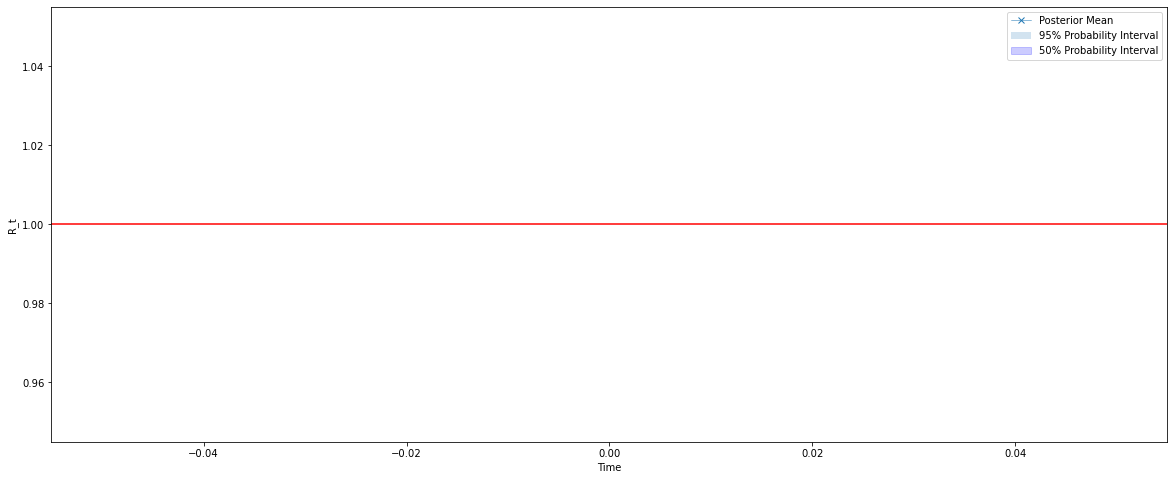

In [331]:
plt.figure(figsize=(20,8))
plt.plot(np.mean(np.exp(trajectories[:, :, 3]), axis=0), label='Posterior Mean', marker='x', linewidth=0.5)
plt.fill_between(np.arange(test_data.shape[0]), np.percentile(np.exp(trajectories[:, :, 3]), 2.5, axis=0), np.percentile(np.exp(trajectories[:, :, 3]), 97.5, axis=0), alpha=0.2, label='95% Probability Interval')
plt.fill_between(np.arange(test_data.shape[0]), np.percentile(np.exp(trajectories[:, :, 3]), 25, axis=0), np.percentile(np.exp(trajectories[:, :, 3]), 75, axis=0), alpha=0.2, label='50% Probability Interval', color='blue')
plt.xlabel('Time')
plt.ylabel('R_t')
plt.legend()
plt.axhline(1, color='red')
plt.show()


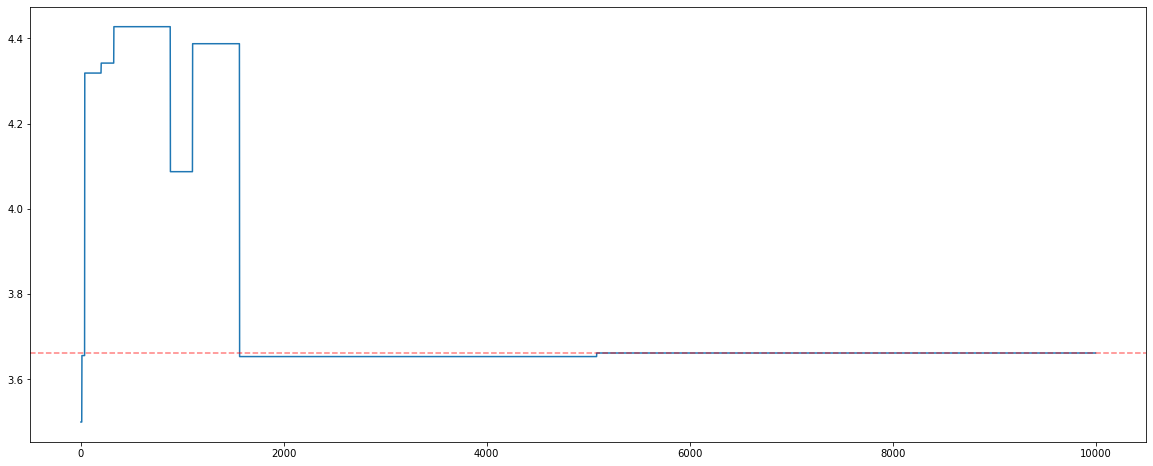

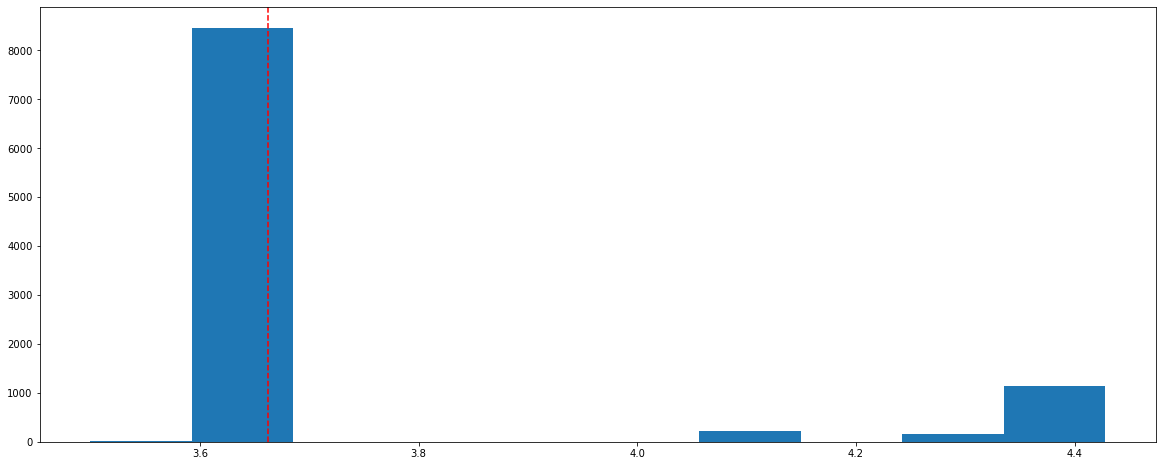

In [229]:
plt.figure(figsize=(20,8))
plt.plot(estimated_R0[:])
plt.axhline(np.median(estimated_R0[:]), color='red', linestyle='--', alpha =0.5)
plt.show()

plt.figure(figsize=(20,8))
plt.hist(estimated_R0[:])
plt.axvline(np.median(estimated_R0[:]), color='red', linestyle='--')
plt.show()

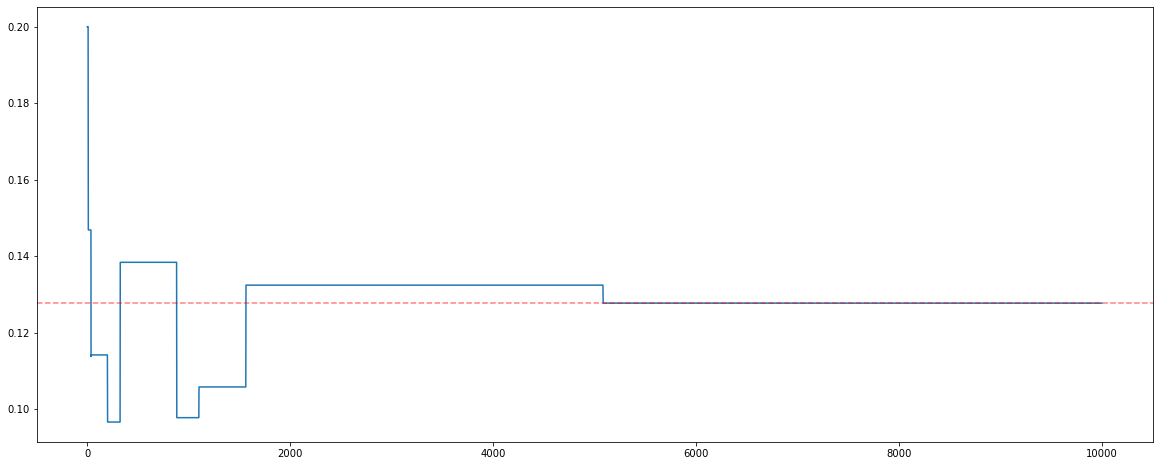

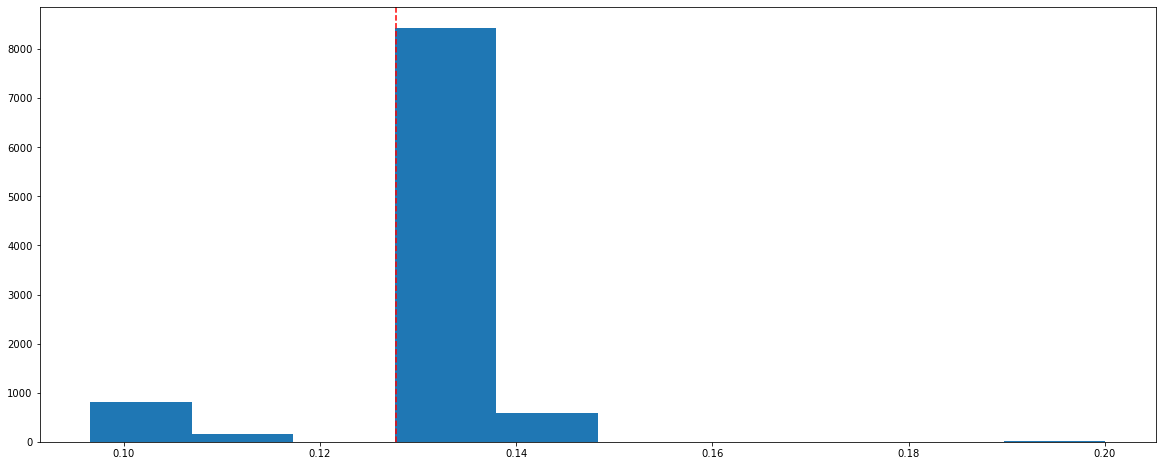

In [230]:
plt.figure(figsize=(20,8))
plt.plot(estimated_alpha[:])
plt.axhline(np.median(estimated_alpha[:]), color='red', linestyle='--', alpha =0.5)
plt.show()

plt.figure(figsize=(20,8))
plt.hist(estimated_alpha[:])
plt.axvline(np.median(estimated_alpha[:]), color='red', linestyle='--')
plt.show()

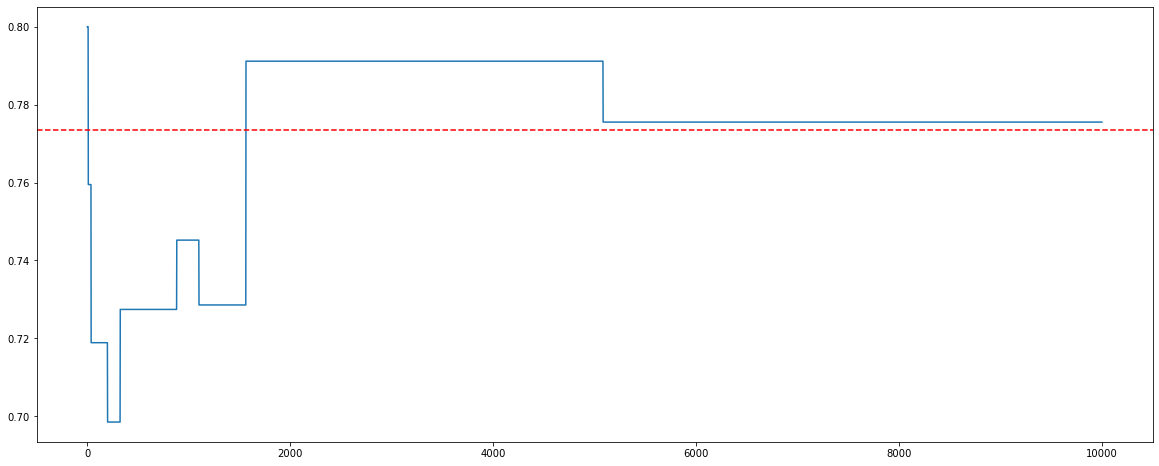

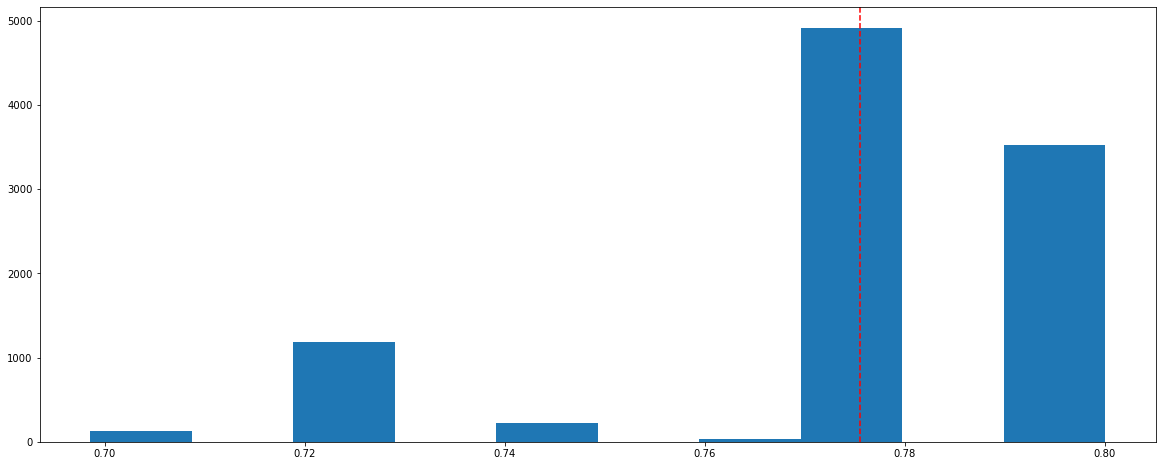

In [231]:
plt.figure(figsize=(20,8))
plt.plot(estimated_gamma[:])
plt.axhline(np.mean(estimated_gamma[:]), color='red', linestyle='--')
plt.show()

plt.figure(figsize=(20,8))
plt.hist(estimated_gamma[:])
plt.axvline(np.median(estimated_gamma[:]), color='red', linestyle='--')
plt.show()

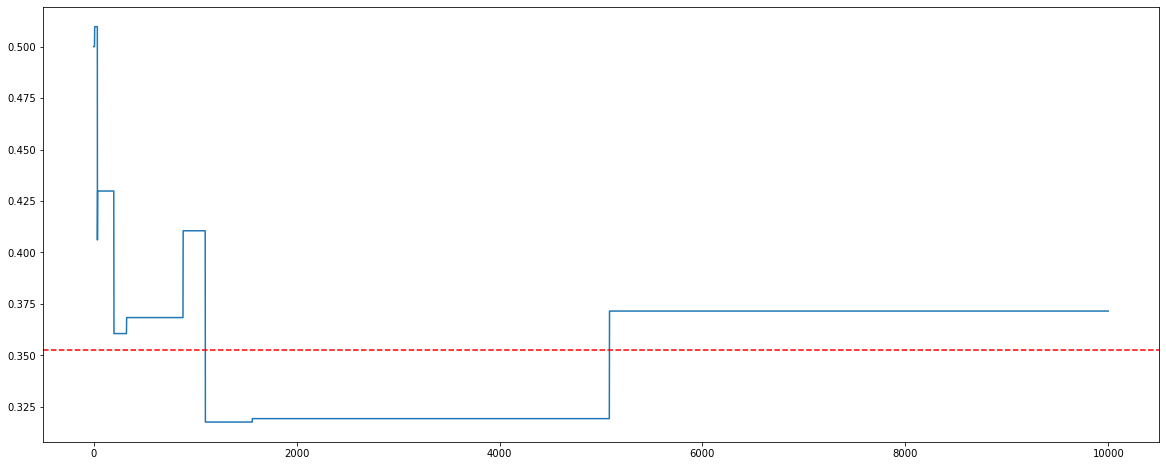

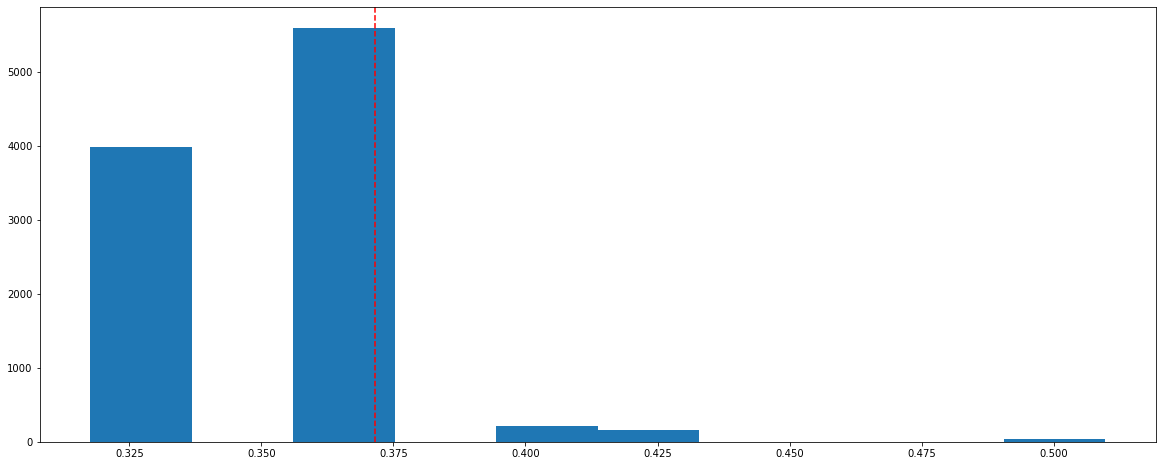

In [232]:
plt.figure(figsize=(20,8))
plt.plot(estimated_sigma[:])
plt.axhline(np.mean(estimated_sigma[:]), color='red', linestyle='--')
plt.show()

plt.figure(figsize=(20,8))
plt.hist(estimated_sigma[:])
plt.axvline(np.median(estimated_sigma[:]), color='red', linestyle='--')
plt.show()